In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd '/content/drive/MyDrive/ML Project'
!pwd

/content/drive/.shortcut-targets-by-id/11vZDVRncVAa-HSQzhEWDgaoMu2b1KfSR/ML Project
/content/drive/.shortcut-targets-by-id/11vZDVRncVAa-HSQzhEWDgaoMu2b1KfSR/ML Project


In [4]:
os.getcwd()

'/content/drive/.shortcut-targets-by-id/11vZDVRncVAa-HSQzhEWDgaoMu2b1KfSR/ML Project'

In [5]:
import tensorflow as tf
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from tensorflow.keras.utils import image_dataset_from_directory

In [6]:
import matplotlib.pyplot as plt


def plot_metric(hist, metric):
    plt.plot(hist.history[f"{metric}"], label=f"{metric}")
    plt.plot(hist.history[f"val_{metric}"], label=f"val_{metric}")
    plt.title(f"{metric} Function Evolution")
    plt.legend()


def plot_hist(hist):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plot_metric(hist, 'loss')

    plt.subplot(1, 2, 2)
    plot_metric(hist, 'accuracy')

In [7]:
butterfly_path = 'butterfly-images40-species/'

We load the dataset using image_dataset_from_directory, which requires every dataset directory to have same top-level folders as those are converted to labels:

In [8]:
# inputs must match the same form the model was originally trained on
IMG_SIZE = 224
image_size = (IMG_SIZE, IMG_SIZE)
# alternately you can use ds.map and tf.image.resize after loading the dataset

In [9]:
train_ds = image_dataset_from_directory(butterfly_path + 'train', image_size=image_size)


Found 9295 files belonging to 75 classes.


In [10]:
validation_ds = image_dataset_from_directory(butterfly_path + 'valid', image_size=image_size)


Found 375 files belonging to 75 classes.


In [11]:
test_ds = image_dataset_from_directory(
    butterfly_path + 'test', image_size=image_size,
    shuffle=False)  # when shuffle is True, it auto shuffles on each iteration
# often we need x_test and y_test separately
x_test = np.concatenate(
    [batch for batch, label in test_ds.as_numpy_iterator()], axis=0)
y_test = np.concatenate(
    [label for batch, label in test_ds.as_numpy_iterator()], axis=0)


Found 375 files belonging to 75 classes.


In [12]:
class_names = train_ds.class_names
class_count = len(class_names)
print(class_names)

['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BECKERS WHITE', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREY HAIRSTREAK', 'INDRA SWALLOW', 'IPHICLUS SISTER', 'JULIA', 'LARGE MARBLE', 'MALACHITE', 'MANGROVE SKIPPER', 'MESTRA', 'METALMARK', 'MILBERTS TORTOISESHELL', 'MONARCH', 'MOURNING CLOAK', 'ORANGE OAKLEAF', 'ORANGE TIP', 'ORCHARD SWALLOW', 'PAINTED LADY', 'PAPER KITE', 'PEACOCK', 'PINE WHITE', 'PIPEVINE SWALLOW', 'POPINJAY', 'PURPLE HAIRSTREAK', 'PURPLISH COPPER', 'QUESTION MARK', 'RED ADMIRA

In [ ]:
img_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.15),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

# Transfer learning

In [ ]:
base_model = tf.keras.applications.MobileNetV3Small(include_top=False,
                                                    input_shape=(IMG_SIZE,
                                                                 IMG_SIZE, 3),
                                                    weights='imagenet')

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(class_count, activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

model.summary()

6709248/6698480 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 75)                76875     
Total params: 1,606,843
Trainable params: 76,875
Non-trainable p

Epoch 1/10


2022-02-19 03:08:32.338362: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


291/291 [==============================] - 95s 305ms/step - loss: 1.9003 - accuracy: 0.6178 - val_loss: 0.9172 - val_accuracy: 0.8080
Epoch 2/10
291/291 [==============================] - 85s 290ms/step - loss: 0.7048 - accuracy: 0.8442 - val_loss: 0.5855 - val_accuracy: 0.8613
Epoch 3/10
291/291 [==============================] - 83s 286ms/step - loss: 0.5047 - accuracy: 0.8824 - val_loss: 0.4586 - val_accuracy: 0.8880
Epoch 4/10
291/291 [==============================] - 83s 285ms/step - loss: 0.4081 - accuracy: 0.9022 - val_loss: 0.4001 - val_accuracy: 0.9067
Epoch 5/10
291/291 [==============================] - 84s 288ms/step - loss: 0.3601 - accuracy: 0.9091 - val_loss: 0.3636 - val_accuracy: 0.9040
Epoch 6/10
291/291 [==============================] - 83s 285ms/step - loss: 0.3071 - accuracy: 0.9225 - val_loss: 0.3459 - val_accuracy: 0.9040
Epoch 7/10
291/291 [==============================] - 84s 289ms/step - loss: 0.2824 - accuracy: 0.9286 - val_loss: 0.3207 - val_accuracy: 0.9

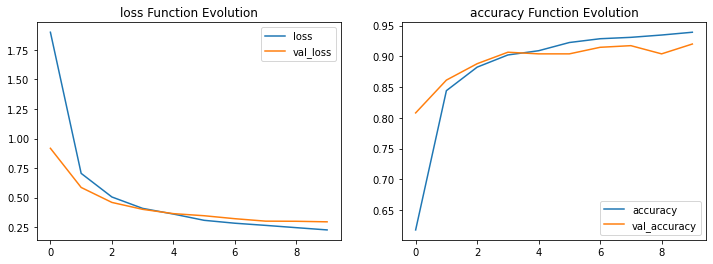

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hist = model.fit(train_ds, validation_data=validation_ds, epochs=10)
plot_hist(hist)

In [ ]:
model.save('mobilenetv3small_10_epochs_transfer.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 75)                76875     
Total params: 1,606,843
Trainable params: 1,594,731
Non-trainable params: 12,112
______________________________________________

Epoch 1/10
291/291 [==============================] - 197s 650ms/step - loss: 0.1755 - accuracy: 0.9518 - val_loss: 0.2426 - val_accuracy: 0.9200
Epoch 2/10
291/291 [==============================] - 189s 649ms/step - loss: 0.1446 - accuracy: 0.9590 - val_loss: 0.2339 - val_accuracy: 0.9307
Epoch 3/10
291/291 [==============================] - 192s 661ms/step - loss: 0.1414 - accuracy: 0.9596 - val_loss: 0.2307 - val_accuracy: 0.9307
Epoch 4/10
291/291 [==============================] - 193s 661ms/step - loss: 0.1315 - accuracy: 0.9606 - val_loss: 0.2193 - val_accuracy: 0.9387
Epoch 5/10
291/291 [==============================] - 190s 653ms/step - loss: 0.1267 - accuracy: 0.9624 - val_loss: 0.2099 - val_accuracy: 0.9387
Epoch 6/10
291/291 [==============================] - 190s 654ms/step - loss: 0.1228 - accuracy: 0.9639 - val_loss: 0.2088 - val_accuracy: 0.9467
Epoch 7/10
291/291 [==============================] - 193s 664ms/step - loss: 0.1126 - accuracy: 0.9677 - val_loss: 0.2118 -

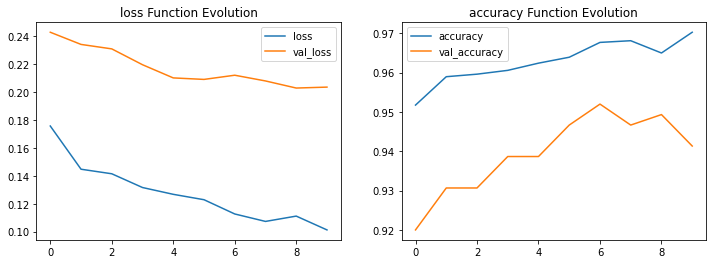

In [ ]:
# While fine-tuning, learning rate must be low to avoid overfitting
# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(
    tf.keras.optimizers.Adam(learning_rate=1e-5),  # Low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])
hist = model.fit(train_ds, validation_data=validation_ds, epochs=10)
plot_hist(hist)

In [ ]:
model.save('mobilenetv3small_10_epochs_transfer_10_epochs_finetune.h5')


In [ ]:
# model = tf.keras.models.load_model('mobilenetv3small_10_epochs_transfer_10_epochs_finetune.h5')
# model.summary()

In [ ]:
y_pred = np.argmax(model.predict(test_ds), axis=-1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      1.00      1.00         5
           2       0.80      0.80      0.80         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       0.83      1.00      0.91         5
          11       1.00      0.80      0.89         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       0.83      1.00      0.91         5
          15       0.83      1.00      0.91         5
          16       1.00      1.00      1.00         5
          17       1.00    

# Training from scratch

In [ ]:
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = img_augmentation(inputs)
outputs = tf.keras.applications.MobileNetV3Small(include_top=True,
                                                 weights=None,
                                                 classes=class_count)(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 75)                1606843   
Total params: 1,606,843
Trainable params: 1,594,731
Non-trainable params: 12,112
_________________________________________________________________


2022-02-18 22:33:18.934901: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
291/291 [==============================] - 237s 782ms/step - loss: 3.2781 - accuracy: 0.1603 - val_loss: 4.3351 - val_accuracy: 0.0133
Epoch 2/40
291/291 [==============================] - 226s 774ms/step - loss: 2.3279 - accuracy: 0.3483 - val_loss: 4.4206 - val_accuracy: 0.0133
Epoch 3/40
291/291 [==============================] - 225s 773ms/step - loss: 1.8754 - accuracy: 0.4556 - val_loss: 4.5745 - val_accuracy: 0.0133
Epoch 4/40
291/291 [==============================] - 225s 773ms/step - loss: 1.5888 - accuracy: 0.5335 - val_loss: 4.8124 - val_accuracy: 0.0133
Epoch 5/40
291/291 [==============================] - 226s 774ms/step - loss: 1.3427 - accuracy: 0.6022 - val_loss: 5.1594 - val_accuracy: 0.0133
Epoch 6/40
291/291 [==============================] - 225s 773ms/step - loss: 1.2260 - accuracy: 0.6361 - val_loss: 6.2229 - val_accuracy: 0.0133
Epoch 7/40
291/291 [==============================] - 226s 775ms/step - loss: 1.0831 - accuracy: 0.6742 - val_loss: 6.9086 -

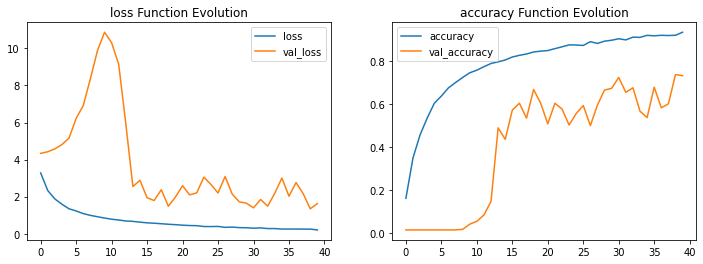

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hist = model.fit(train_ds, validation_data=validation_ds, epochs=40)
plot_hist(hist)

In [ ]:
model.save('mobilenetv3small_40_epochs_scratch.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
y_pred = np.argmax(model.predict(test_ds), axis=-1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.56      1.00      0.71         5
           2       1.00      0.20      0.33         5
           3       0.75      0.60      0.67         5
           4       0.43      0.60      0.50         5
           5       0.80      0.80      0.80         5
           6       0.67      0.80      0.73         5
           7       1.00      0.60      0.75         5
           8       0.00      0.00      0.00         5
           9       0.71      1.00      0.83         5
          10       0.67      0.80      0.73         5
          11       0.60      0.60      0.60         5
          12       0.83      1.00      0.91         5
          13       0.75      0.60      0.67         5
          14       0.71      1.00      0.83         5
          15       1.00      0.60      0.75         5
          16       1.00      0.80      0.89         5
          17       0.80    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Try improving with smaller learning rate

In [ ]:
model = tf.keras.models.load_model('mobilenetv3small_40_epochs_scratch.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 MobilenetV3small (Functiona  (None, 75)               1606843   
 l)                                                              
                                                                 
Total params: 1,606,843
Trainable params: 1,594,731
Non-trainable params: 12,112
_________________________________________________________________


Epoch 1/10
291/291 [==============================] - 2260s 8s/step - loss: 0.1883 - accuracy: 0.9364 - val_loss: 0.9691 - val_accuracy: 0.8107
Epoch 2/10
291/291 [==============================] - 365s 1s/step - loss: 0.1519 - accuracy: 0.9478 - val_loss: 0.6941 - val_accuracy: 0.8587
Epoch 3/10
291/291 [==============================] - 366s 1s/step - loss: 0.1327 - accuracy: 0.9534 - val_loss: 0.5531 - val_accuracy: 0.8880
Epoch 4/10
291/291 [==============================] - 367s 1s/step - loss: 0.1342 - accuracy: 0.9538 - val_loss: 0.4798 - val_accuracy: 0.9040
Epoch 5/10
291/291 [==============================] - 365s 1s/step - loss: 0.1170 - accuracy: 0.9617 - val_loss: 0.4388 - val_accuracy: 0.9093
Epoch 6/10
291/291 [==============================] - 362s 1s/step - loss: 0.1097 - accuracy: 0.9629 - val_loss: 0.4099 - val_accuracy: 0.9120
Epoch 7/10
291/291 [==============================] - 360s 1s/step - loss: 0.1072 - accuracy: 0.9628 - val_loss: 0.3947 - val_accuracy: 0.914

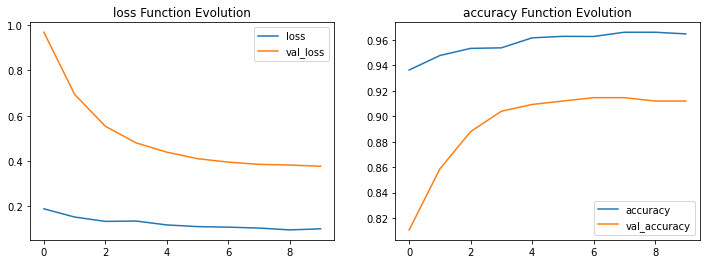

In [ ]:
model.compile(tf.keras.optimizers.Adam(learning_rate=.00001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
hist = model.fit(train_ds, validation_data=validation_ds, epochs=10)
plot_hist(hist)

In [ ]:
model.save('mobilenetv3small_50_epochs_scratch.h5')

In [ ]:
y_pred = np.argmax(model.predict(test_ds), axis=-1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.60      0.75         5
           3       1.00      1.00      1.00         5
           4       0.71      1.00      0.83         5
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00      0.60      0.75         5
           9       1.00      1.00      1.00         5
          10       0.80      0.80      0.80         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       0.83      1.00      0.91         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      0.80      0.89         5
          17       0.83    

## Always checkpoint the best model when training in colab

In [ ]:
#@markdown ---
#@markdown ### Enter checkpoint file path (already existing folder):
checkpoint_filepath = 'checkpoint_mobilenetv3small' #@param {type:'string'}
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True)

Epoch 1/5
291/291 [==============================] - 385s 1s/step - loss: 0.0909 - accuracy: 0.9683 - val_loss: 0.3738 - val_accuracy: 0.9120
Epoch 2/5
291/291 [==============================] - 370s 1s/step - loss: 0.0919 - accuracy: 0.9683 - val_loss: 0.3723 - val_accuracy: 0.9120
Epoch 3/5
291/291 [==============================] - 375s 1s/step - loss: 0.0945 - accuracy: 0.9672 - val_loss: 0.3717 - val_accuracy: 0.9120
Epoch 4/5
291/291 [==============================] - 369s 1s/step - loss: 0.0914 - accuracy: 0.9687 - val_loss: 0.3711 - val_accuracy: 0.9120
Epoch 5/5
291/291 [==============================] - 378s 1s/step - loss: 0.0960 - accuracy: 0.9670 - val_loss: 0.3708 - val_accuracy: 0.9120


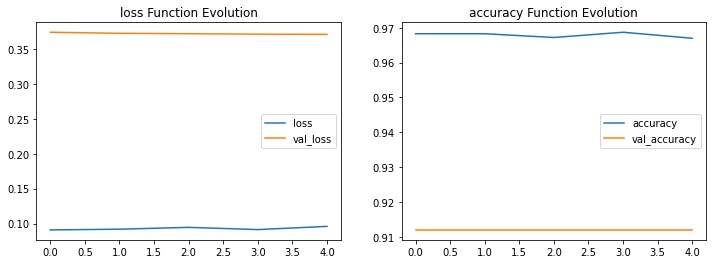

In [ ]:
EPOCHS = 5 #@param {type:"slider", min:1, max:10, step:1}

model.compile(tf.keras.optimizers.Adam(learning_rate=.000001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Model weights are saved at the end of every epoch, if it's the best seen so far.
hist = model.fit(train_ds, validation_data=validation_ds, epochs=EPOCHS, callbacks=[model_checkpoint_callback])
plot_hist(hist)

In [ ]:
# The best model weights are loaded into the model.
model.load_weights(checkpoint_filepath)

model.save('mobilenetv3small_scratch_best.h5')

In [ ]:
y_pred = np.argmax(model.predict(test_ds), axis=-1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      0.60      0.75         5
           3       1.00      1.00      1.00         5
           4       0.71      1.00      0.83         5
           5       0.83      1.00      0.91         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00      0.60      0.75         5
           9       1.00      1.00      1.00         5
          10       0.80      0.80      0.80         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       0.83      1.00      0.91         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      0.80      0.89         5
          17       0.83    

# Similar image (same species) recommender

In [13]:
model = tf.keras.models.load_model('mobilenetv3small_10_epochs_transfer_10_epochs_finetune.h5')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 img_augmentation (Sequentia  (None, 224, 224, 3)      0         
 l)                                                              
                                                                 
 MobilenetV3small (Functiona  (None, 1, 1, 1024)       1529968   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                             

First we embed the test set and calculate all near neighbours. Theoritically we should probably remove last softmax and use l2_normalize so that we can calculate cosine similarity via dot products. But here, dot products of final output worked better.

In [14]:
embeddings = model.predict(test_ds)
y_pred = np.argmax(embeddings, axis=-1)
near_neighbours_per_example = 4

gram_matrix = np.einsum("ae,be->ab", embeddings, embeddings)
# gram_matrix indicates similarity, we want most similar indices in descending, hence negate gram_matrix and use argsort
# Note that every image is most similar to itself, hence the shift by 1:
near_neighbours = np.argsort(-gram_matrix)[:, 1 : near_neighbours_per_example + 1]

query_classes = []
recommended_classes = []
for idx, species in enumerate(y_test):
    for nn_idx in near_neighbours[idx]:
        query_classes.append(species)
        recommended_classes.append(y_test[nn_idx])

print(classification_report(query_classes, recommended_classes))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        20
           1       1.00      1.00      1.00        20
           2       0.75      0.60      0.67        20
           3       1.00      1.00      1.00        20
           4       0.68      0.75      0.71        20
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        20
           7       1.00      1.00      1.00        20
           8       0.83      1.00      0.91        20
           9       1.00      1.00      1.00        20
          10       0.80      0.60      0.69        20
          11       0.81      0.85      0.83        20
          12       0.95      1.00      0.98        20
          13       1.00      1.00      1.00        20
          14       1.00      1.00      1.00        20
          15       0.83      1.00      0.91        20
          16       1.00      1.00      1.00        20
          17       1.00    

## Visualizing the recommender

In [15]:
def show_collage(examples):
    R, C = examples.shape
    fig, axes = plt.subplots(R, C, figsize=(20, 20))

    for i in range(R):
        for j in range(C):
            idx = examples[i][j]
            axes[i][j].imshow(x_test[idx] / 255.0)
            axes[i][j].set_title(f"True: {class_names[y_test[idx]]}\nPredict: {class_names[(y_pred[idx])]}")
            axes[i][j].axis('off')

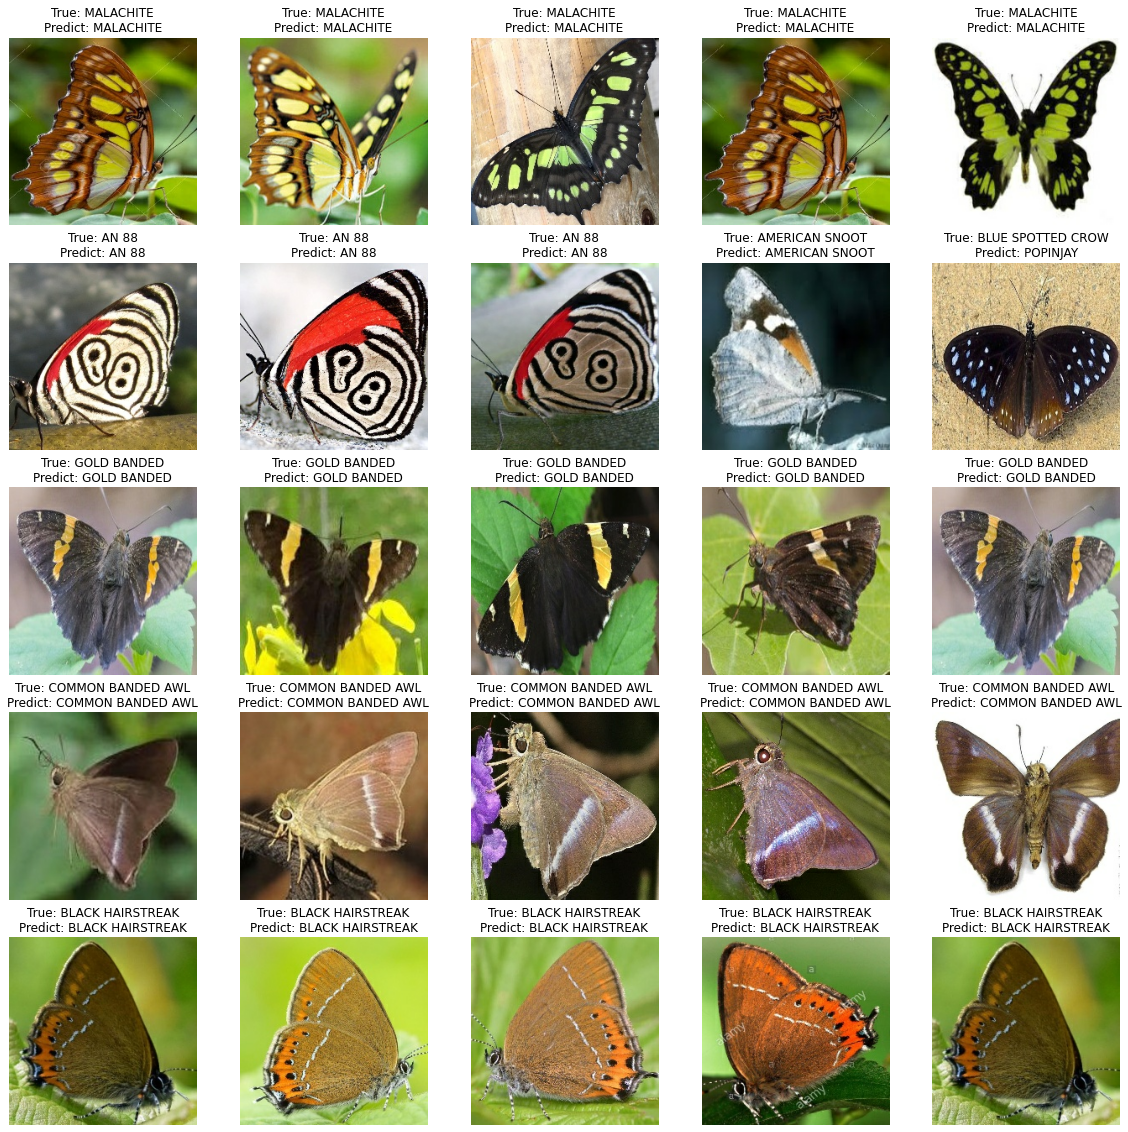

In [16]:
num_collage_examples = 5

examples = np.empty(
    (
        num_collage_examples,
        near_neighbours_per_example + 1
    ),
    dtype=np.uint8,
)
for row_idx in range(num_collage_examples):
    temp_idx = np.random.randint(0, len(y_test))
    examples[row_idx, 0] = temp_idx
    anchor_near_neighbours = near_neighbours[temp_idx]
    for col_idx, nn_idx in enumerate(anchor_near_neighbours):
        examples[row_idx, col_idx + 1] = nn_idx

show_collage(examples)

## Visualizing image classification

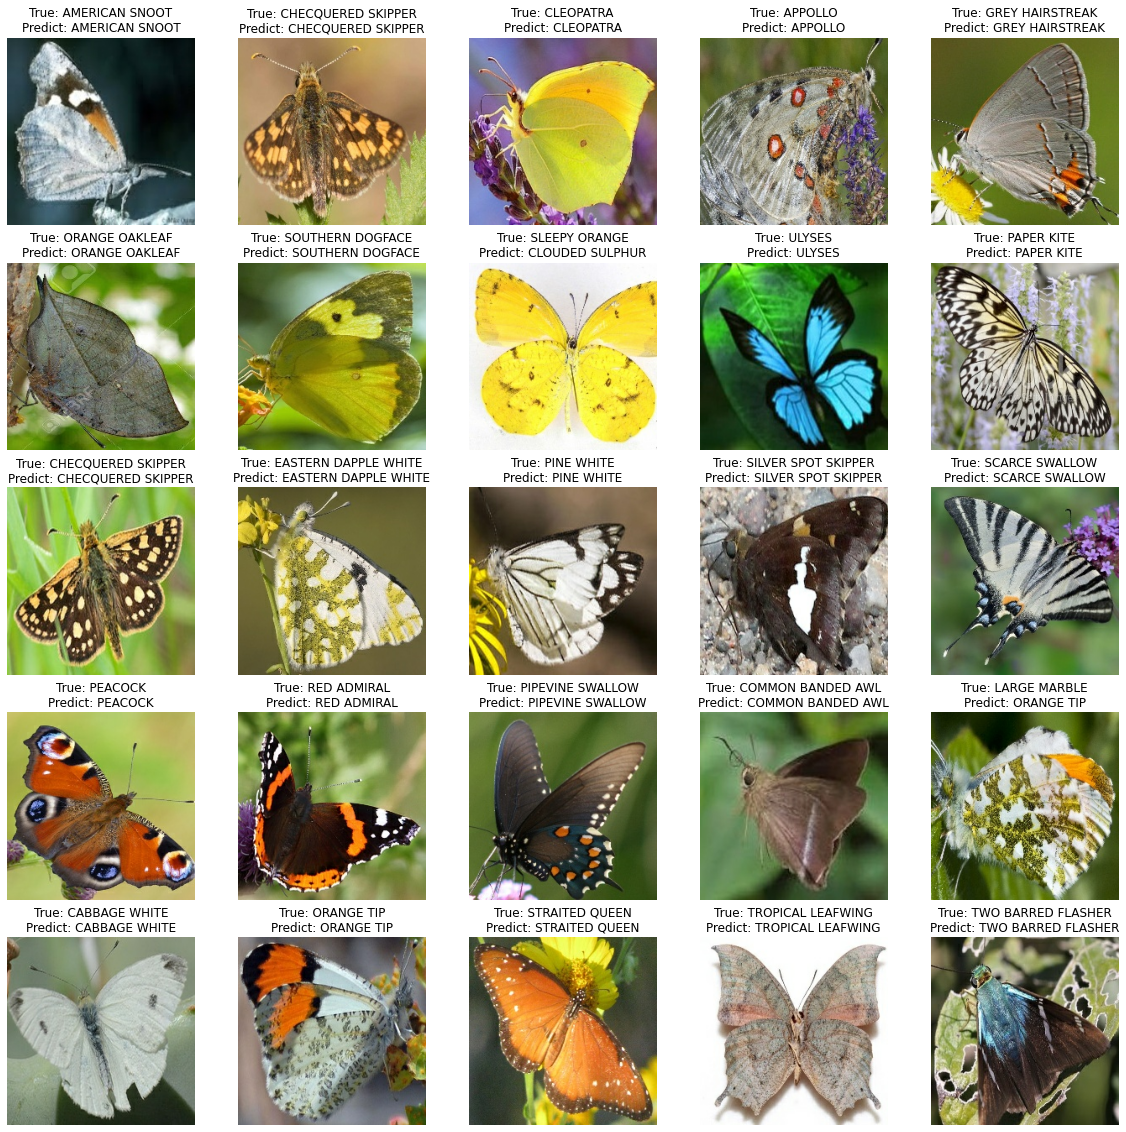

In [17]:
show_collage(np.random.randint(0, len(y_test), (5, 5)))